### Import libraries

In [14]:
# To store the data

%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# To create interactive plots
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# To shift lists
from collections import deque

# To compute similarities between vectors
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:

# To use recommender systems
import surprise as sp
from surprise.model_selection import cross_validate

import tensorflow as tf
import keras

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check Keras version
print("Keras version:", keras.__version__)

# To create deep learning models
from keras.layers import Input

In [3]:
# To create sparse matrices
from scipy.sparse import coo_matrix

# To light fm
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

# To stack sparse matrices
from scipy.sparse import vstack

/Users/benazirrowe/opt/anaconda3/lib/python3.9/site-packages/lightfm/_lightfm_fast.py:9: UserWarning:

LightFM was compiled without OpenMP support. Only a single thread will be used.



### Load data

In [64]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print(current_directory)

/Users/benazirrowe/Documents/deepLearningRecommender/notebooks


In [6]:
# Load product info
product_info = pd.read_csv('../data/raw/archive/product_info.csv')
product_info.head()


product_id               product_name  brand_id brand_name  loves_count  \
0    P473671    Fragrance Discovery Set      6342      19-69         6320   
1    P473668    La Habana Eau de Parfum      6342      19-69         3827   
2    P473662  Rainbow Bar Eau de Parfum      6342      19-69         3253   
3    P473660       Kasbah Eau de Parfum      6342      19-69         3018   
4    P473658  Purple Haze Eau de Parfum      6342      19-69         2691   

   rating  reviews            size                      variation_type  \
0  3.6364     11.0             NaN                                 NaN   
1  4.1538     13.0  3.4 oz/ 100 mL  Size + Concentration + Formulation   
2  4.2500     16.0  3.4 oz/ 100 mL  Size + Concentration + Formulation   
3  4.4762     21.0  3.4 oz/ 100 mL  Size + Concentration + Formulation   
4  3.2308     13.0  3.4 oz/ 100 mL  Size + Concentration + Formulation   

  variation_value  ... online_only out_of_stock  sephora_exclusive  \
0             NaN  ...           1            0                  0   
1  3.4 oz/ 100 mL  ...           1            0                  0   
2  3.4 oz/ 100 mL  ...           1            0                  0   
3  3.4 oz/ 100 mL  ...           1            0                  0   
4  3.4 oz/ 100 mL  ...           1            0                  0   

                                          highlights  primary_category  \
0  ['Unisex/ Genderless Scent', 'Warm &Spicy Scen...         Fragrance   
1  ['Unisex/ Genderless Scent', 'Layerable Scent'...         Fragrance   
2  ['Unisex/ Genderless Scent', 'Layerable Scent'...         Fragrance   
3  ['Unisex/ Genderless Scent', 'Layerable Scent'...         Fragrance   
4  ['Unisex/ Genderless Scent', 'Layerable Scent'...         Fragrance   

   secondary_category  tertiary_category  child_count  child_max_price  \
0   Value & Gift Sets  Perfume Gift Sets            0              NaN   
1               Women            Perfume            2             85.0   
2               Women            Perfume            2             75.0   
3               Women            Perfume            2             75.0   
4               Women            Perfume            2             75.0   

   child_min_price  
0              NaN  
1             30.0  
2             30.0  
3             30.0  
4             30.0  

[5 rows x 27 columns]

In [7]:
product_info.shape


(8494, 27)

In [8]:
product_info.columns

Index(['product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count',
       'rating', 'reviews', 'size', 'variation_type', 'variation_value',
       'variation_desc', 'ingredients', 'price_usd', 'value_price_usd',
       'sale_price_usd', 'limited_edition', 'new', 'online_only',
       'out_of_stock', 'sephora_exclusive', 'highlights', 'primary_category',
       'secondary_category', 'tertiary_category', 'child_count',
       'child_max_price', 'child_min_price'],
      dtype='object')

In [9]:
product_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          8494 non-null   object 
 1   product_name        8494 non-null   object 
 2   brand_id            8494 non-null   int64  
 3   brand_name          8494 non-null   object 
 4   loves_count         8494 non-null   int64  
 5   rating              8216 non-null   float64
 6   reviews             8216 non-null   float64
 7   size                6863 non-null   object 
 8   variation_type      7050 non-null   object 
 9   variation_value     6896 non-null   object 
 10  variation_desc      1250 non-null   object 
 11  ingredients         7549 non-null   object 
 12  price_usd           8494 non-null   float64
 13  value_price_usd     451 non-null    float64
 14  sale_price_usd      270 non-null    float64
 15  limited_edition     8494 non-null   int64  
 16  new   

Indicator variables: 15  limited_edition, new, online_only, out_of_stock    

In [ ]:
Integer variables: loves_count, rating, reviews, price_usd, value_price_usd, sale_price_usd

In [ ]:
Categorical: primary_category, secondary_category, tertiary_category

In [10]:
product_info.primary_category.unique()

array(['Fragrance', 'Bath & Body', 'Mini Size', 'Hair', 'Makeup',
       'Skincare', 'Tools & Brushes', 'Men', 'Gifts'], dtype=object)

In [11]:
product_info.secondary_category.unique()

array(['Value & Gift Sets', 'Women', 'Body Moisturizers', 'Fragrance',
       'Men', 'Candles & Home Scents', 'Body Care',
       'Hair Styling & Treatments', 'Shampoo & Conditioner', 'Mini Size',
       'Lip', 'Moisturizers', 'Treatments', 'Eye Care',
       'Lip Balms & Treatments', 'Sunscreen', 'Cleansers', 'Masks',
       'Skincare', 'Face', 'Eye', 'Cheek', 'Hair', 'Tools',
       'Brushes & Applicators', 'Makeup Palettes', 'Beauty Tools',
       'Accessories', 'Makeup', 'Bath & Shower', 'Wellness',
       'High Tech Tools', 'Shop by Concern', nan, 'Self Tanners',
       'Shaving', 'Hair Tools', 'Nail', 'Beauty Accessories',
       'Beauty Supplements', 'Other Needs', 'Bath & Body'], dtype=object)

In [12]:
product_info.child_count.unique()

array([  0,   2,  10,   1,   3,   5,  11,  17,   9,   6,  15,  23,   4,
        49,   7,  21,   8,  24,  12,  78,  19,  39,  14,  29,  34,  25,
        16,  22,  41,  13,  20,  43,  50,  37,  55,  27,  30, 105,  40,
        35,  31,  33,  18,  28,  38,  26,  45,  32,  59,  47,  73,  46,
        36,  63,  51])

<AxesSubplot:xlabel='count', ylabel='primary_category'>

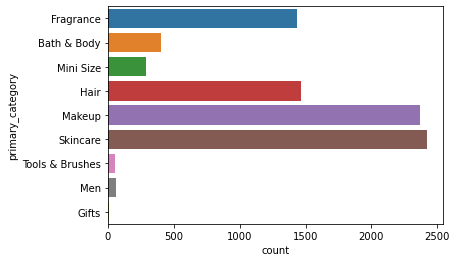

In [15]:
sns.countplot(y=product_info['primary_category'])

(14,)


<AxesSubplot:>

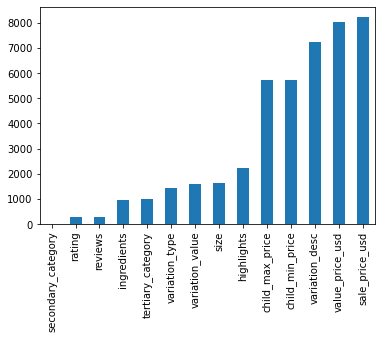

In [16]:
#Explore the missing data

missing = product_info.isnull().sum()
missing = missing[missing > 0]
print(missing.shape)
missing.sort_values(inplace=True)
missing.plot.bar()

There are many auxilliary variables that do not exist for every product. I would first drop the columns:sale_price_usd, value_price_usd, variation_desc, child_min_price, child_max_price, hightlights, tertiary_category, ingredients and variation_value. Next I woud drop the rows for which reviews or ratings do not exist. 

Text(0.5, 1.0, 'Price (USD) distribution')

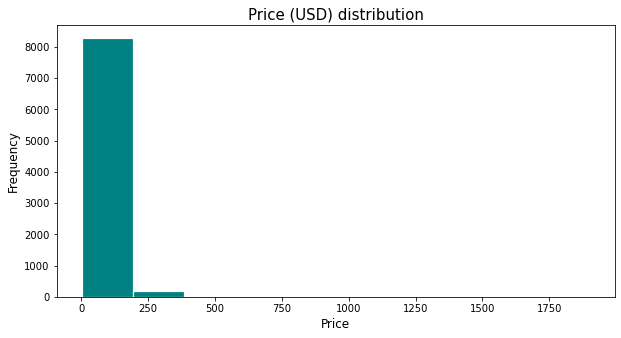

In [45]:
fig = plt.figure(figsize=(10, 5))
plt.hist(product_info['price_usd'],color='teal', edgecolor='white', linewidth=1.2)

# Add labels and title
plt.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Price (USD) distribution', fontsize=15)

The cutoff for bottom 99% is:  107.0


Text(0.5, 1.0, '90 % of products')

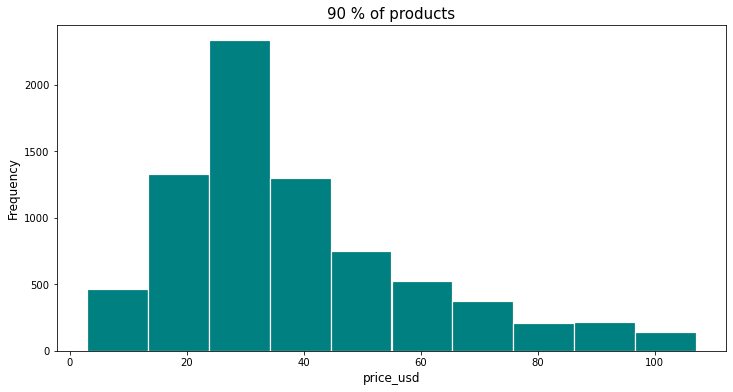

In [46]:
#zoom in on reviews

sorted_data = product_info.sort_values(by='price_usd', ascending=True)
sorted_data = sorted_data.reset_index(drop=True)
rows_to_keep = int(round(len(sorted_data)*0.90))
cutoff = sorted_data.loc[rows_to_keep,'price_usd']
bottom_90_percent = sorted_data.iloc[:rows_to_keep, :]
print("The cutoff for bottom 99% is: ", cutoff)
top_10_percent = sorted_data.iloc[rows_to_keep:, :]

fig = plt.figure(figsize=(12, 6))
plt.hist(bottom_90_percent['price_usd'],color='teal', edgecolor='white', linewidth=1.2)

# Add labels and title
plt.ticklabel_format(useOffset=False, style='plain')

plt.xlabel('price_usd', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('90 % of products', fontsize=15)



Text(0.5, 1.0, 'Ratings distribution')

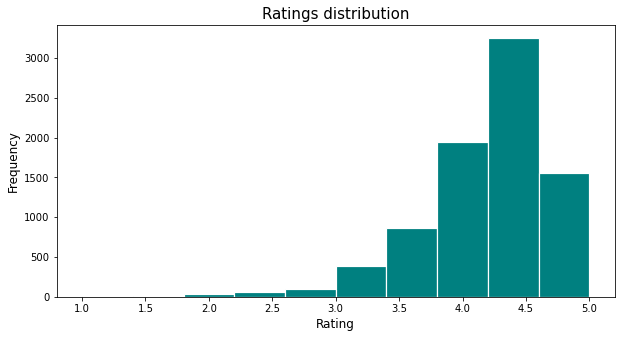

In [19]:
fig = plt.figure(figsize=(10, 5))
plt.hist(product_info['rating'],color='teal', edgecolor='white', linewidth=1.2)

# Add labels and title
plt.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Ratings distribution', fontsize=15)

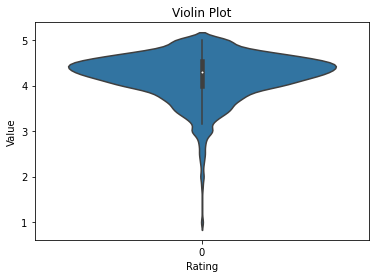

In [43]:
# Create violin plot
sns.violinplot(data=product_info['rating'])

# Add labels and title
plt.xlabel('Rating')
plt.ylabel('Value')
plt.title('Violin Plot')

# Show the plot
plt.show()

Text(0.5, 1.0, 'Reviews distribution')

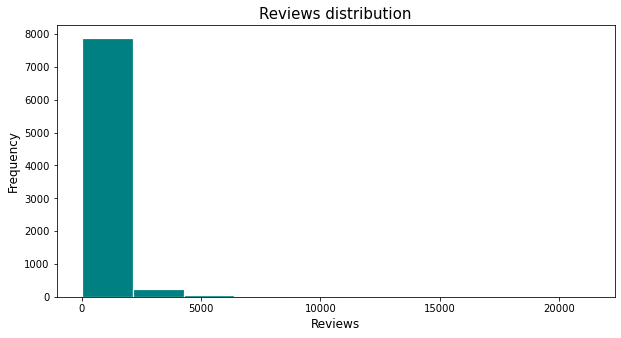

In [21]:
fig = plt.figure(figsize=(10, 5))
plt.hist(product_info['reviews'],color='teal', edgecolor='white', linewidth=1.2)

# Add labels and title
plt.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('Reviews', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Reviews distribution', fontsize=15)

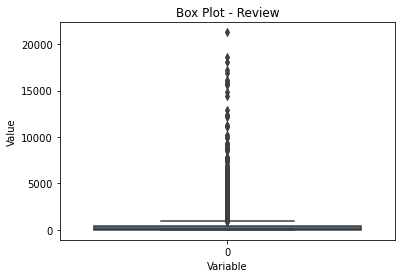

In [44]:
sns.boxplot(data=product_info['reviews'])

# Add labels and title
plt.xlabel('Variable')
plt.ylabel('Value')
plt.title('Box Plot - Review')

# Show the plot
plt.show()

The cutoff for bottom 99% is:  1466.0


Text(0.5, 1.0, '90 % of Reviews')

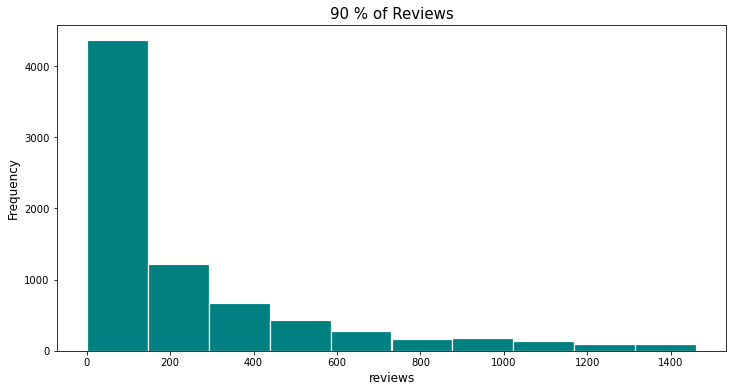

In [26]:
#zoom in on reviews

sorted_data = product_info.sort_values(by='reviews', ascending=True)
sorted_data = sorted_data.reset_index(drop=True)
rows_to_keep = int(round(len(sorted_data)*0.90))
cutoff = sorted_data.loc[rows_to_keep,'reviews']
bottom_90_percent = sorted_data.iloc[:rows_to_keep, :]
print("The cutoff for bottom 99% is: ", cutoff)
top_10_percent = sorted_data.iloc[rows_to_keep:, :]

fig = plt.figure(figsize=(12, 6))
plt.hist(bottom_90_percent['reviews'],color='teal', edgecolor='white', linewidth=1.2)

# Add labels and title
plt.ticklabel_format(useOffset=False, style='plain')

plt.xlabel('reviews', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('90 % of Reviews', fontsize=15)


Text(0.5, 1.0, 'Primary category')

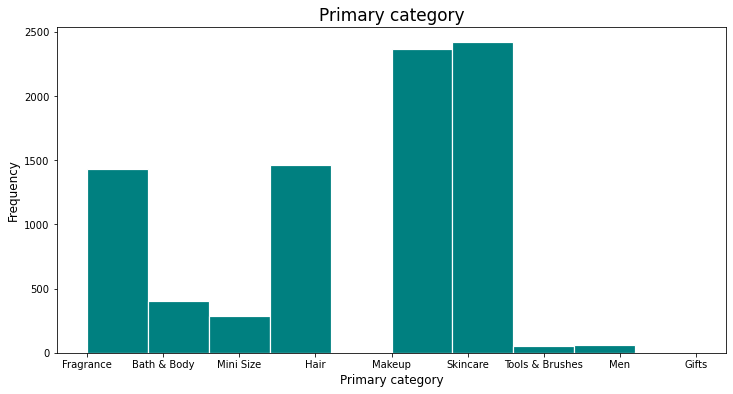

In [29]:
fig = plt.figure(figsize=(12, 6))
plt.hist(product_info['primary_category'],color='teal', edgecolor='white', linewidth=1.2)

# Add labels and title


plt.xlabel('Primary category', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Primary category', fontsize=17)

<AxesSubplot:xlabel='count', ylabel='secondary_category'>

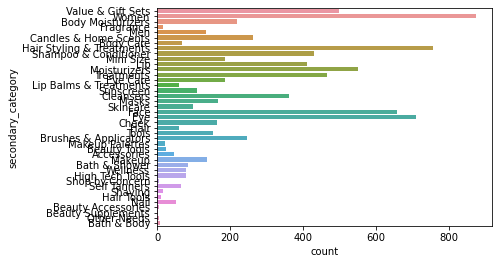

In [39]:
sns.countplot(y=product_info['secondary_category'])

Text(0.5, 1.0, 'Loves distribution')

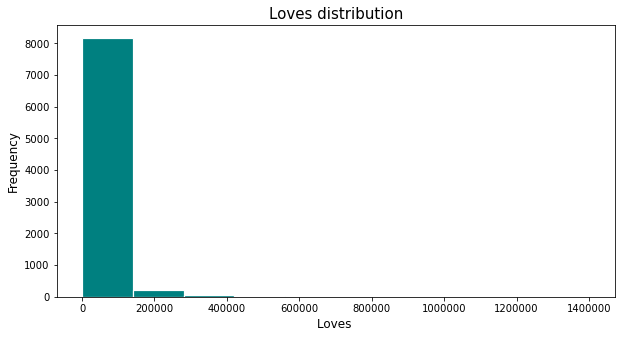

In [31]:
fig = plt.figure(figsize=(10, 5))
plt.hist(product_info['loves_count'],color='teal', edgecolor='white', linewidth=1.2)

# Add labels and title
plt.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('Loves ', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Loves distribution', fontsize=15)

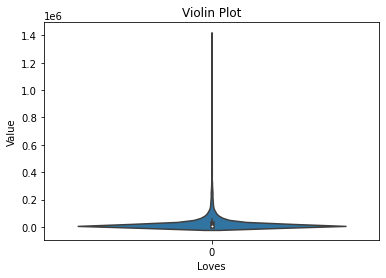

In [42]:
# Create violin plot
sns.violinplot(data=product_info['loves_count'])

# Add labels and title
plt.xlabel('Loves')
plt.ylabel('Value')
plt.title('Violin Plot')

# Show the plot
plt.show()

/Users/benazirrowe/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='limited_edition', ylabel='count'>

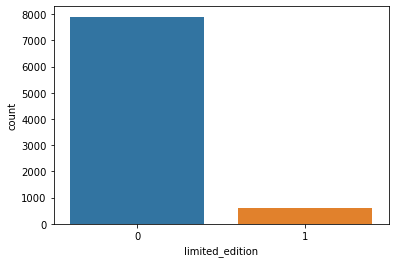

In [32]:
sns.countplot(product_info.limited_edition)

<AxesSubplot:xlabel='new', ylabel='count'>

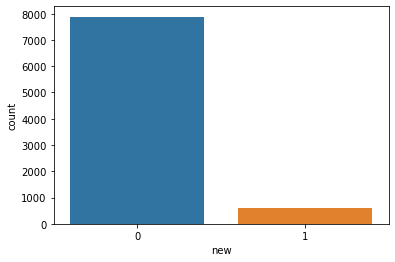

In [35]:
sns.countplot(x= product_info['new'])

<AxesSubplot:xlabel='out_of_stock', ylabel='count'>

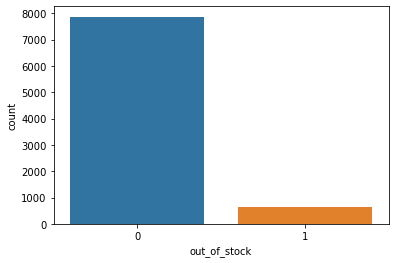

In [36]:
sns.countplot(x= product_info['out_of_stock'])

<AxesSubplot:xlabel='sephora_exclusive', ylabel='count'>

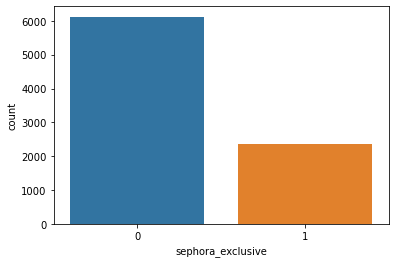

In [37]:
sns.countplot(x= product_info['sephora_exclusive'])

Text(0.5, 1.0, 'Child count distribution')

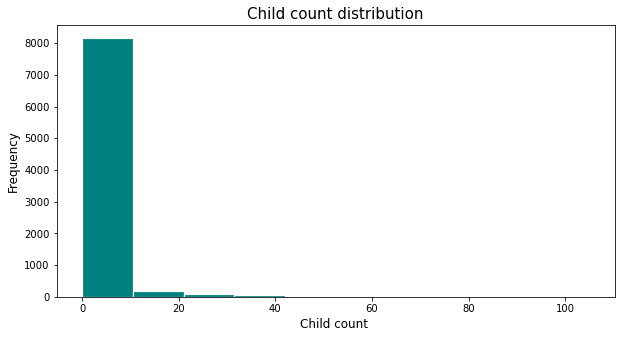

In [38]:
fig = plt.figure(figsize=(10, 5))
plt.hist(product_info['child_count'],color='teal', edgecolor='white', linewidth=1.2)

# Add labels and title
plt.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('Child count ', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Child count distribution', fontsize=15)

In [47]:
#importing required packages
import pandas_profiling
#importing the data
df = product_info
#descriptive statistics
pandas_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Based on the report, we can drop sale price and value price since they are very correlated. Also drop child min price and max price, drop tertiary category. Drop variation variables and size for now. 

In [55]:
# Drop columns 'B' and 'C'
df = product_info.drop(['sale_price_usd', 'value_price_usd', 'variation_type', 'variation_value', 'variation_desc','child_max_price', 'child_min_price',
                       'tertiary_category', 'ingredients', 'size', 'highlights'], axis=1)

# Display the updated DataFrame
print(df.shape)


(8494, 16)


(3,)


<AxesSubplot:>

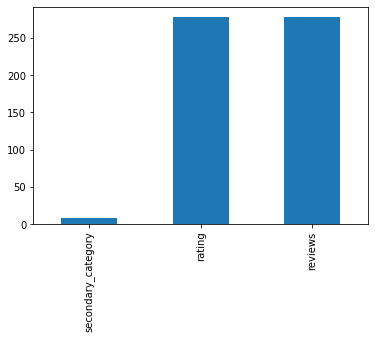

In [56]:
#Explore the missing data

missing = df.isnull().sum()
missing = missing[missing > 0]
print(missing.shape)
missing.sort_values(inplace=True)
missing.plot.bar()

In [60]:
# Drop rows with missing values
df = df.dropna()

# Display the updated DataFrame
print(df.shape)

(8209, 16)


In [65]:
df.to_csv('../data/processed/product_info_clean.csv', index=False)